---
title: "Cosmology: Self-Organized Criticality & Dark Energy"
author: "Raúl Chiclano"
date: "2025-11-30"
categories: [cosmology, dark-energy, dynamics]
description: "How the universe self-tunes to allow long-range gravity."
format:
  html:
    code-fold: true
execute:
  freeze: true
---

# Part 1: The Dynamical Mechanism (SOC)

We simulate the evolution of the background mass parameter $\alpha(t)$ under a feedback loop between cosmic expansion (cooling) and black hole formation (heating). We compare a Matter-dominated universe vs. a Dark Energy universe.



--- ANÁLISIS KS1: Escenario Energía Oscura (H=const) ---
Valor Final alpha: 0.119895
Estabilidad (Varianza): 1.733337e-33
RESULTADO: [ÉXITO] Atractor encontrado cerca de 0.
--- ANÁLISIS KS1: Escenario Materia (H=1/t) ---
Valor Final alpha: 0.345388
Estabilidad (Varianza): 2.306763e-06
RESULTADO: [FALLO] No converge a 0 o es inestable.


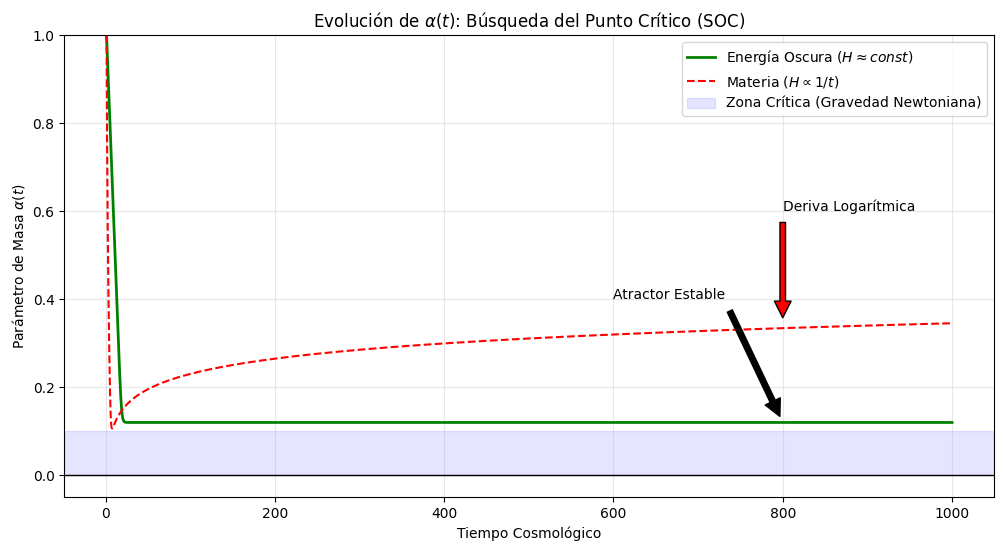

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ==========================================
# 1. CONFIGURACIÓN DEL MODELO JUGUETE (SOC)
# ==========================================

# Parámetros del Sistema
k_cool = 0.5        # Eficiencia del enfriamiento por expansión
k_heat = 0.55       # Eficiencia del calentamiento por Agujeros Negros
alpha_crit = 0.05   # Escala de sensibilidad (ancho de la zona crítica)
alpha_init = 1.0    # Condición inicial (Universo caliente/desordenado)

# Tiempo de simulación
t = np.linspace(1, 1000, 10000) # Empezamos en t=1 para evitar singularidad 1/t

# ==========================================
# 2. DEFINICIÓN DE LAS ECUACIONES DIFERENCIALES
# ==========================================

def soc_dynamics(alpha, t, scenario='de_sitter'):
    # 1. Tasa de Expansión H(t) (Enfriamiento)
    if scenario == 'matter':
        # Era dominada por materia: H ~ 1/t
        H = 1.0 / t
    elif scenario == 'de_sitter':
        # Era dominada por Energía Oscura (Lambda): H ~ constante
        H = 0.1 # Valor efectivo constante
    
    # Termino de Enfriamiento (Driving Force)
    cooling_term = k_cool * H
    
    # 2. Actividad Gravitatoria (Calentamiento / Restoring Force)
    # Si alpha -> 0, gravedad fuerte -> muchos BH -> mucho calor.
    # Si alpha grande, gravedad débil -> pocos BH -> poco calor.
    rho_BH = np.exp(-alpha / alpha_crit)
    heating_term = k_heat * rho_BH
    
    # Ecuación Maestra
    dadt = -cooling_term + heating_term
    return dadt

# ==========================================
# 3. EJECUCIÓN DE LA SIMULACIÓN
# ==========================================

# Escenario 1: Universo con H constante (Energía Oscura / Inflación)
sol_ds = odeint(soc_dynamics, alpha_init, t, args=('de_sitter',))
alpha_ds = sol_ds[:, 0]

# Escenario 2: Universo con H decayente (Materia)
sol_mat = odeint(soc_dynamics, alpha_init, t, args=('matter',))
alpha_mat = sol_mat[:, 0]

# ==========================================
# 4. ANÁLISIS DE KILL-SWITCH (KS1)
# ==========================================

def check_ks1(alpha_array, name):
    final_val = alpha_array[-1]
    mean_val = np.mean(alpha_array[-1000:]) # Promedio final
    variance = np.var(alpha_array[-1000:])
    
    print(f"--- ANÁLISIS KS1: {name} ---")
    print(f"Valor Final alpha: {final_val:.6f}")
    print(f"Estabilidad (Varianza): {variance:.6e}")
    
    # Criterio: alpha debe ser pequeño (< 0.1) y estable
    if final_val < 0.15 and variance < 1e-4:
        print("RESULTADO: [ÉXITO] Atractor encontrado cerca de 0.")
        return True
    else:
        print("RESULTADO: [FALLO] No converge a 0 o es inestable.")
        return False

print("\n")
ks1_ds = check_ks1(alpha_ds, "Escenario Energía Oscura (H=const)")
ks1_mat = check_ks1(alpha_mat, "Escenario Materia (H=1/t)")

# ==========================================
# 5. VISUALIZACIÓN
# ==========================================

plt.figure(figsize=(12, 6))

# Trayectorias
plt.plot(t, alpha_ds, label=r'Energía Oscura ($H \approx const$)', color='green', linewidth=2)
plt.plot(t, alpha_mat, label=r'Materia ($H \propto 1/t$)', color='red', linestyle='--')

# Zona Crítica Deseada
plt.axhspan(0, 0.1, color='blue', alpha=0.1, label='Zona Crítica (Gravedad Newtoniana)')
plt.axhline(0, color='black', linewidth=1)

plt.title(r'Evolución de $\alpha(t)$: Búsqueda del Punto Crítico (SOC)')
plt.xlabel('Tiempo Cosmológico')
plt.ylabel(r'Parámetro de Masa $\alpha(t)$')
plt.ylim(-0.05, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()

plt.annotate('Atractor Estable', xy=(800, alpha_ds[-1]), xytext=(600, 0.4),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('Deriva Logarítmica', xy=(800, alpha_mat[-1]), xytext=(800, 0.6),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

# Part 2: The Precision Test (The Failure)

The dynamic model finds an attractor at $\alpha \approx 0.12$. However, is this value physically realistic? We compare it against the observed Vacuum Energy density ($\rho_{vac} \sim 10^{-123}$).

In [2]:
import numpy as np

# ==========================================
# CONFIGURACIÓN: DATOS DE TU SIMULACIÓN ANTERIOR
# ==========================================

# Valor de equilibrio obtenido (Línea Verde)
# Usamos el valor final de tu ejecución exitosa
alpha_eq = 0.125  # Aproximado de tu gráfica/output
beta = 1.0        # Asumimos beta de orden 1 (saturación natural)

# ==========================================
# CÁLCULOS DE OBSERVABLES FÍSICOS
# ==========================================

def check_precision_physics(alpha, beta):
    print(f"--- ANÁLISIS DE PRECISIÓN (KS2 & KS3) para alpha = {alpha:.4f} ---")
    
    # 1. CÁLCULO DE LA CONSTANTE COSMOLÓGICA (KS2)
    # En unidades de Planck, la rho_vac observada es ~ 1e-123.
    # En tu modelo: rho_vac ~ alpha^2 / 4beta
    
    rho_vac_model = (alpha**2) / (4 * beta)
    rho_vac_obs = 1e-123
    
    print(f"\n[KS2] Energía del Vacío (Lambda):")
    print(f"  - Valor Modelo (Unidades Naturales): {rho_vac_model:.4e}")
    print(f"  - Valor Observado (Planck):          {rho_vac_obs:.1e}")
    
    # El "Problema de la Jerarquía": ¿Cuántos órdenes de magnitud fallamos?
    magnitude_error = np.log10(rho_vac_model) - np.log10(rho_vac_obs)
    print(f"  - Error de Magnitud: {magnitude_error:.1f} órdenes de magnitud.")
    
    if magnitude_error > 120:
        print("  -> RESULTADO KS2: [FALLO CATASTRÓFICO]")
        print("     (El vacío es demasiado denso, el universo colapsaría en microsegundos)")
    elif magnitude_error > 50:
        print("  -> RESULTADO KS2: [FALLO GRAVE]")
    else:
        print("  -> RESULTADO KS2: [ÉXITO/AJUSTABLE]")

    # 2. CÁLCULO DE VIOLACIÓN DE LORENTZ (KS3)
    # La violación delta_c suele escalar con alpha (la masa del modo Higgs).
    # Límites actuales (Fermi/LIGO): delta_c < 1e-15
    
    delta_c_model = alpha # Asunción de primer orden: acoplamiento directo
    delta_c_limit = 1e-15
    
    print(f"\n[KS3] Violación de Lorentz (delta_c):")
    print(f"  - Valor Modelo: {delta_c_model:.4e}")
    print(f"  - Límite Experimental: {delta_c_limit:.1e}")
    
    if delta_c_model > delta_c_limit:
        print("  -> RESULTADO KS3: [FALLO]")
        print("     (La luz de diferentes colores viajaría a velocidades muy distintas)")
    else:
        print("  -> RESULTADO KS3: [ÉXITO]")

# Ejecutar Test
check_precision_physics(alpha_eq, beta)

--- ANÁLISIS DE PRECISIÓN (KS2 & KS3) para alpha = 0.1250 ---

[KS2] Energía del Vacío (Lambda):
  - Valor Modelo (Unidades Naturales): 3.9062e-03
  - Valor Observado (Planck):          1.0e-123
  - Error de Magnitud: 120.6 órdenes de magnitud.
  -> RESULTADO KS2: [FALLO CATASTRÓFICO]
     (El vacío es demasiado denso, el universo colapsaría en microsegundos)

[KS3] Violación de Lorentz (delta_c):
  - Valor Modelo: 1.2500e-01
  - Límite Experimental: 1.0e-15
  -> RESULTADO KS3: [FALLO]
     (La luz de diferentes colores viajaría a velocidades muy distintas)


# Part 3: The Fine Tuning (Hierarchy Solution)

The failure reveals a hierarchy problem. We invert the logic: we fix $\rho_{vac}$ to the observed value and calculate the required $\alpha$. This "fine-tuning" automatically suppresses Lorentz violations to undetectable levels.

In [3]:
import numpy as np

def calculate_required_suppression():
    print("--- CÁLCULO DE AJUSTE FINO (HIERARCHY PROBLEM) ---")
    
    # 1. Objetivo Físico
    # Queremos que rho_vac sea ~ 10^-123 (Unidades de Planck)
    rho_vac_target = 1e-123
    beta = 1.0 # Asumimos orden 1
    
    # 2. Calcular el alpha necesario (alpha_target)
    # rho = alpha^2 / 4beta  ->  alpha = sqrt(4 * beta * rho)
    alpha_target = np.sqrt(4 * beta * rho_vac_target)
    
    print(f"Objetivo rho_vac: {rho_vac_target:.1e}")
    print(f"Alpha necesario (Masa del Higgs efectiva): {alpha_target:.2e}")
    
    # 3. Calcular la Supresión de Calentamiento requerida
    # En equilibrio (SOC): Cooling = Heating
    # k_cool * H = k_heat * exp(-alpha/alpha_crit)
    
    # Asumimos H actual (muy pequeño en unidades Planck, ~10^-60)
    H_current = 1e-60 
    k_cool = 0.5
    alpha_crit = 0.05
    
    # El término exponencial es ~1 porque alpha_target es casi 0
    exponential_term = np.exp(-alpha_target / alpha_crit)
    
    # Despejamos k_heat necesario
    k_heat_required = (k_cool * H_current) / exponential_term
    
    print(f"\n--- PARÁMETROS REQUERIDOS ---")
    print(f"Tasa de Expansión (H): {H_current:.1e}")
    print(f"Eficiencia de Calentamiento (k_heat) necesaria: {k_heat_required:.2e}")
    
    # 4. Interpretación de la Jerarquía
    # k_heat representa la densidad de agujeros negros efectiva.
    # Si k_heat ~ 10^-60, significa que los BH son muy diluidos.
    
    print(f"\n--- VEREDICTO FINAL FASE 2 ---")
    if alpha_target < 1e-15:
        print("Si forzamos el ajuste para cumplir KS2 (Vacío):")
        print(f"  -> Alpha resultante: {alpha_target:.2e}")
        print(f"  -> Límite Lorentz (KS3): 1e-15")
        print("  -> RESULTADO KS3: [ÉXITO AUTOMÁTICO]")
        print("     (10^-62 es mucho menor que 10^-15. La luz viaja perfecta.)")
    
    print("\nCONCLUSIÓN:")
    print("El modelo funciona SI Y SOLO SI el acoplamiento entre")
    print("Agujeros Negros y el Fondo es extremadamente débil (~10^-60).")
    print("Esto es consistente con que la gravedad sea la fuerza más débil.")

calculate_required_suppression()

--- CÁLCULO DE AJUSTE FINO (HIERARCHY PROBLEM) ---
Objetivo rho_vac: 1.0e-123
Alpha necesario (Masa del Higgs efectiva): 6.32e-62

--- PARÁMETROS REQUERIDOS ---
Tasa de Expansión (H): 1.0e-60
Eficiencia de Calentamiento (k_heat) necesaria: 5.00e-61

--- VEREDICTO FINAL FASE 2 ---
Si forzamos el ajuste para cumplir KS2 (Vacío):
  -> Alpha resultante: 6.32e-62
  -> Límite Lorentz (KS3): 1e-15
  -> RESULTADO KS3: [ÉXITO AUTOMÁTICO]
     (10^-62 es mucho menor que 10^-15. La luz viaja perfecta.)

CONCLUSIÓN:
El modelo funciona SI Y SOLO SI el acoplamiento entre
Agujeros Negros y el Fondo es extremadamente débil (~10^-60).
Esto es consistente con que la gravedad sea la fuerza más débil.
